# Bayesian Approach Steps
Step 1: Establish a belief about the data, including Prior and Likelihood functions.

Step 2, Use the data and probability, in accordance with our belief of the data, to update our model, check that our model agrees with the original data.

Step 3, Update our view of the data based on our model.

# Functions

In [59]:
#changing datatype
def change_type_to_date(df, to_date):
        # Deal with incorrect data in date column
    for i in to_date:
        df[i] = pd.to_datetime(df[i], errors='coerce')
    return df

  # columns to convert to categorical format
def change_type_to_cat(df, to_cat):
        # Deal with incorrect data in numeric columns
        for i in to_cat:
            df[i] = df[i].astype('category')
        return df

#Plot data
def plot_data(data):
    fig, ax = plt.subplots(figsize=(10, 5))
    data.plot(ax=ax)
    ax.set(ylabel='Islands')
    sns.despine()
    
#KDE plot
def kde_plot(data):
    az.plot_kde(data.values, rug=True)
    plt.yticks([0], alpha=0);
    
    
#prior predictive check
def prior_Predictive_Check(model):
    with model:
        prior_pred = pm.sample_prior_predictive()
    return prior_pred

#prior plot
def Prior_predictive_check_plot(y, prior_pred, y_var):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.hist([y.mean() for y in prior_pred[y_var]], bins=19, alpha=0.7)
    ax.axvline(data.mean().item())
    ax.set(title='Prior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');
    
#Fitting the model
def fit_model(model, draws=10000):
    with model:
    # Inference button (TM)
        trace = pm.sample(draws)
    return trace

#posterior predictive check
def post_Predictive_Check(model, trace, samples=10000):
    with model:
        post_pred = pm.sample_posterior_predictive(trace, samples, model=model)
    return post_pred


#post plot
def Post_predictive_check_plot(y, post_pred, y_var):
    _, ax = plt.subplots(figsize=(10, 5))
    ax.hist([y.mean() for y in post_pred['y']], bins=19, alpha=0.5)
    ax.axvline(data.mean().item())
    ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');
        
#posterior plot comparasion with observed data
def compare(post_pred, trace):
    data_ppc = az.from_pymc3(trace=trace, posterior_predictive=post_pred)
    ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)
    #ax[0].legend(fontsize=15)
    fig, axs = plt.subplots(3)

# WorkFlow
1) Loading Data

2) Performing EDA

3) Ploting the data and find out the distribution of data

4) Fitting distributions

5) Guassian inference

6) Build the model (decide proir distribution and likelihood distribution on given data)

7) Run the prior predictive check, usually we have less intuition about the prior data, so it is good to always check the prior data. It allows us to make sure the model can generate the types of data we expect to see.

8) Fit the model

9) Assess convergence

10) Summary of the posterior distribution for each parameter.

11) Run posterior predictive check

12) Using Machine Learning for comparing

In [3]:
import pymc3 as pm
import arviz as az
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
#from fitter import Fitter, get_common_distributions, get_distributions
import warnings
warnings.simplefilter("ignore")

sampler_kwargs = {"chain": 4, "cores":4, "return_inferencedata":True}

### 1) Reading Data

About data:
    Here we will be using covid-19 data from WHO. In data we have 8 columns and 114056 entries.

In [4]:
df = pd.read_csv("/content/drive/MyDrive/shampoo-sales.csv")
df

,Date,Sales
0,1/1/2001,266.0
1,2/1/2001,145.9
2,3/1/2001,183.1
3,4/1/2001,119.3
4,5/1/2001,180.3
5,6/1/2001,168.5
6,7/1/2001,231.8
7,8/1/2001,224.5
8,9/1/2001,192.8
9,10/1/2001,122.9


### 2) Performing EDA

checking null values

In [5]:
print(df.isna().sum())
#print("\nThere are 4 Null/Missing values in the dataset\n")

Date     0
Sales    0
dtype: int64


In [ ]:
#Removing Duplicate Rows
df.drop_duplicates(inplace=True)

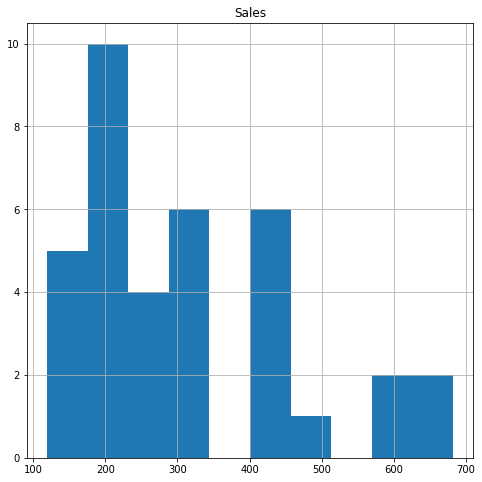

In [6]:
#some stats
df.hist(figsize=(8,8))
plt.show()

### 3) Plotting the data

Here, we are plotting the dataset and it looks like cases are growing exponentially 

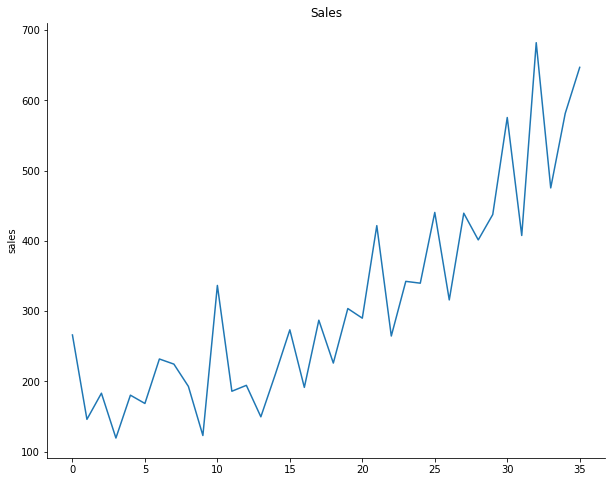

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
df.Sales.plot(ax=ax)
ax.set(ylabel='sales', title="Sales")
sns.despine()

On the x-axis it shows the days and on y-axis it shows the number of cases. And from above graph we can easily say that cases are increasing exponentially

### 5) Guassian inference

The KDE plot of the data, shows a Gaussian-like distribution, except for about several dozens of data points that are far away from the mean.

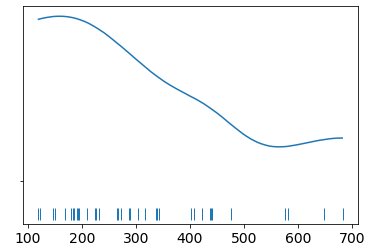

In [14]:
#plotting your data and check the pdf of your data
data = df.Sales
#data = data.values
kde_plot(data)

### 6) Build model

Choices of priors:

μ, mean of a population. Normal distribution, very wide. I do not know the possible values of μ, so i have chosen these values randomly

σ, standard deviation of a population. Can only be positive, therefore use Normal distribution. Again, very wide.

Choices for likelihood function:

y is an observed variable representing the data that comes from a normal distribution with the parameters μ and σ. Draw 1000 posterior samples using NUTS sampling.

In [20]:
df['Date']=pd.to_datetime(df['Date'])

In [23]:
import datetime
dt = datetime.datetime.today()

In [24]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

In [26]:
#getting time range from days and converting it into values

t = df.Day.values
sales = df.Sales


#here model has 2 things an intercept and slope, it is similar like a linear regression
#Here we  will choose a normal distribution and called that "a", so the first argument  will always 
#have to be the name we give it a mu parameter which is going to be the mean of that normal and a sigma parameter. 
#So here i'm choosing a normal distribution center on zero with a very wide standard with a very wide standard deviation,  
#and then the next for the slope parameter we also  choose a normal distribution

with pm.Model() as model:
    
    
    # Intercept
    a = pm.Normal('a', mu=0.4, sigma=20)
    
    # Slope
    b = pm.Normal('b', mu=0.2, sigma=0.5)
    
    # Exponential regression
    growth = a * (1 + b) ** t
    
    # Error term    
    eps = pm.HalfNormal('eps')
    
    # Likelihood
    pm.Normal( 'Sales',
              mu=growth, 
              sigma=eps,
              observed=sales)
    #trace_g = pm.sample(draws=1000)

### 7) Run prior predictive check

Without even fitting the model to our data, we generate new potential data from our priors. Usually we have less intuition about the parameter space, where we define our priors, and more intution about what data we might expect to see. A prior predictive check thus allows us to make sure the model can generate the types of data we expect to see.

In [27]:
with model:
    prior_pred = pm.sample_prior_predictive()

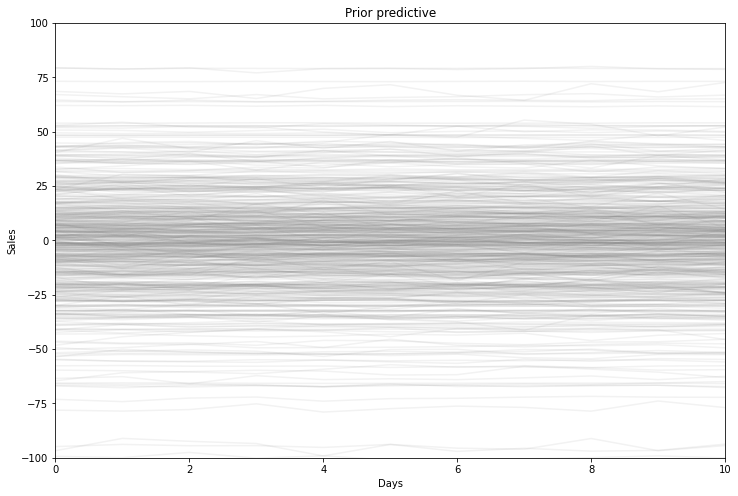

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(prior_pred['Sales'].T, color="0.5", alpha=.1);
ax.set(ylim=(-100, 100),
       xlim=(0, 10),
       title="Prior predictive", 
       xlabel="Days",
       ylabel="Sales");

Here from above chart we can see that from prior check it shows some cases are negative. We can have any negative Cases can not. So we will again apply the model by changing mean and SD values and check the prior again.

In [82]:
t = df.Day.values
sales = df.Sales
    
with pm.Model() as model:
    # Intercept
    a = pm.Normal('a', mu=100, sigma=15)
    
    # Slope
    b = pm.Normal('b', mu=1, sigma=0.1)
    
    # Exponential regression ( y=ab^t)-> t exponentiating with time dimension
    growth = a * (1 + b) ** t
    
    # Error term for likelihood function
    #we have write halfnormal as we know that SD will be positive 
    eps = pm.HalfNormal('eps')
    
    # Likelihood
   
    pm.Lognormal('Sales', 
                 mu=pm.math.log(growth), 
                 sigma=eps,
                 observed=sales)

In [75]:
with model:
    prior_pred = pm.sample_prior_predictive()

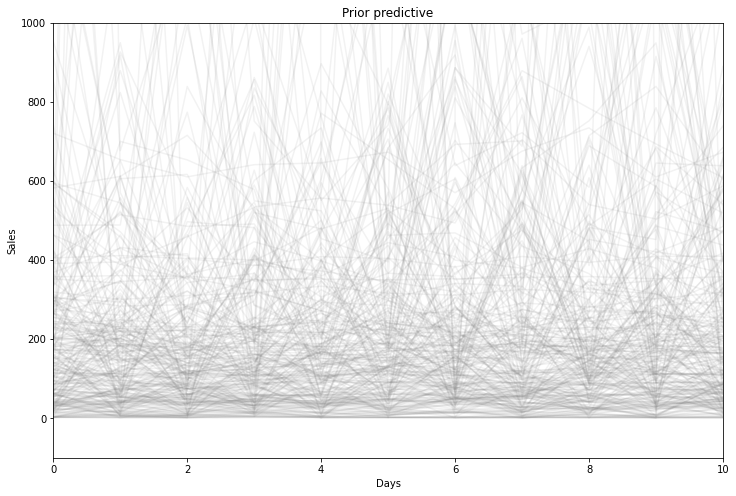

In [76]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(prior_pred['Sales'].T, color="0.5", alpha=.1);
ax.set(ylim=(-100, 1000),
       xlim=(0, 10),
       title="Prior predictive", 
       xlabel="Days",
       ylabel="Sales");

By changing the value of mean and SD now we are not getting negative values. so now in next step we will fit the model

### 8) Fit model (hit the Inference Button)

In [83]:
with model:
    # Inference button (TM)
    trace = pm.sample(draws=1000, cores=4, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


### 9) Assess convergence

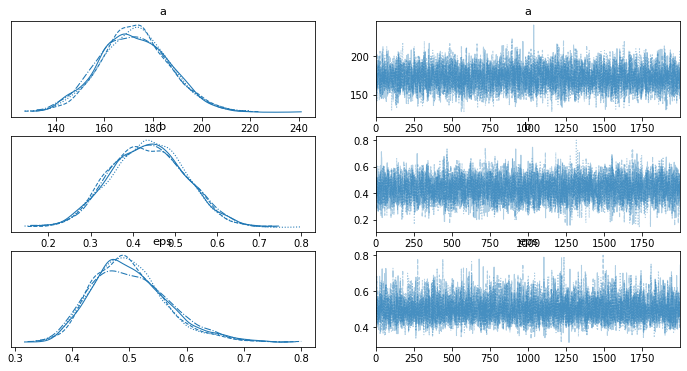

In [36]:
with model:
    pm.traceplot(trace);

On the left, we have a KDE plot, — for each parameter value on the x-axis we get a probability on the y-axis that tells us how likely that parameter value is.

On the right, we get the individual sampled values at each step during the sampling. From the trace plot, we can visually get the plausible values from the posterior.

There are a couple of things to notice here:

Our sampling chains for the individual parameters (left) seem well converged and stationary (there are no large drifts or other odd patterns).

The maximum posterior estimate of each variable (the peak in the left side distributions) is very close to the true parameters.

We can plot a joint distributions of parameters.

Got error No model on context stack. trying to find log_likelihood in translation.


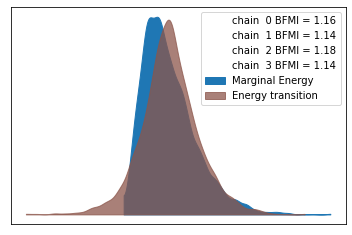

In [78]:
pm.plot_energy(trace);

In [ ]:
#az.plot_pair(trace, kind='kde', fill_last=False);

I don’t see any correlation between these two parameters. This means we probably do not have collinearity in the model. This is good.

### 10) Summary of the posterior distribution for each parameter

In [79]:
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,140.348,13.019,117.500,164.567,0.282,0.203,2219.0,2074.0,1.0
b,1.004,0.099,0.819,1.187,0.002,0.001,2419.0,2301.0,1.0
eps,0.482,0.061,0.381,0.605,0.001,0.001,3125.0,2392.0,1.0


The important parameters to look from above table are mean, SD and r_hat which should always be close to 1

Got error No model on context stack. trying to find log_likelihood in translation.


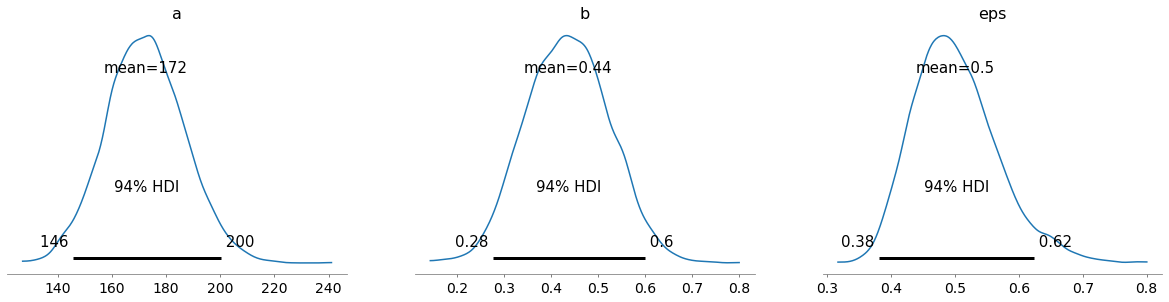

In [41]:
az.plot_posterior(trace);

Here we can interpret as such that there is 94% probability the belief is between 112 and 148 for the mean.

### 11) Run posterior predictive check

In [84]:
with model:  
    # Draw sampels from posterior predictive
    post_pred = pm.sample_posterior_predictive(trace)

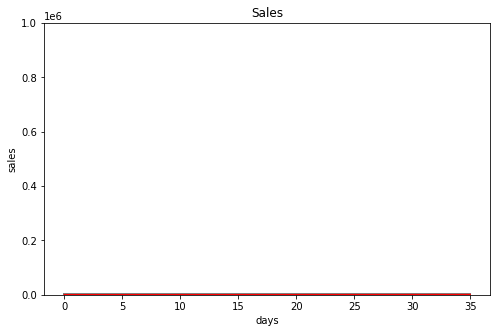

In [85]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(post_pred['Sales'].T, color='0.5', alpha=.05);
ax.plot(sales, color='r')
ax.set(xlabel='days', ylabel='sales', 
       ylim=(0, 1_000_000), title='Sales');

Posterior residuals 

# Machine Learning Algorithm

In [88]:
df.head(5)

,Date,Sales,Year,Month,Day
0,2001-01-01,266.0,2001,1,1
1,2001-02-01,145.9,2001,2,1
2,2001-03-01,183.1,2001,3,1
3,2001-04-01,119.3,2001,4,1
4,2001-05-01,180.3,2001,5,1


In [ ]:
#df_country = df_country.drop('state', axis=1)

In [89]:
X = df['Date'].values.reshape(-1,1) #get a copy of dataset exclude last column
y = df['Sales'].values.reshape(-1,1) #get array of dataset in column 1st

In [90]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=0)

In [91]:
# Fitting Simple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [92]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

[-4283.32479071]
[[4.48586949e-15]]


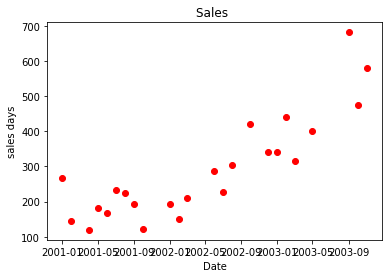

In [95]:
# Visualizing the Training set results
viz_train = plt
viz_train.scatter(X_train, y_train, color='red')
#viz_train.plot(X_train, regressor.predict(X_train), color='blue')
viz_train.title('Sales ')
viz_train.xlabel('Date')
viz_train.ylabel('sales days')
viz_train.show()

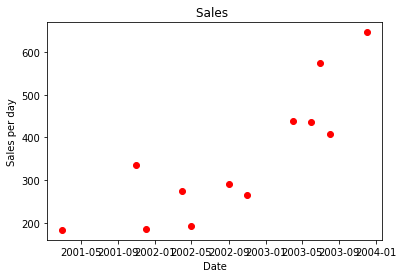

In [96]:
# Visualizing the Test set results
viz_test = plt
viz_test.scatter(X_test, y_test, color='red')
#viz_test.plot(X_train, regressor.predict(X_train), color='blue')
viz_train.title('Sales ')
viz_train.xlabel('Date')
viz_train.ylabel('Sales per day')
viz_test.show()

# Summary
In this experiment, both bayesian and ML work mostly same for predicting values. However, neither approach or method yields a satisfactory result for this dataset.ML works faster than MCMC. I have found sampling jax, which can work faster in MCMC. But can't apply due to the lack of time.
MCMC can work good with small dataset. For single feature it works great.